

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Final Project - Algorithmic Biases in Facial Recognition



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

## Table of Contents

- [Overview](#overview)
- [UTKFace Data](#data)
    - Data labels
    - Verification of labels
    - Exploratory data analysis
- [Transfer Learning Models](#models)
    - Image preprocessing
    - Data generator
    - Model setup
- [Results](#results)
    - Base case gender classification with pre-trained model(s)
    - Gender classification using non-neural net methods
    - Gender classification with pre-trained model(s) and race-labeled data
    - Model improvement methods and results
- Conclusions & Recommendations for Future Work

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#PLEASE RUN THIS CELL 
import os
import re
import shutil
import glob, cv2
import tarfile
import requests
import getpass
import sys
import logging

import dlib
from tqdm import tqdm
from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import tensorflow as tf
from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.layers import *
from keras.utils import plot_model
import random
from IPython.display import clear_output


Using TensorFlow backend.


<a id='overview'></a>

## Overview</b></div>

Algorithmic bias for machine learning can be introduced to an algorithm during training when a racially imbalanced training data set is used. The resulting model will inherently have more error in identifying underrepresented races, and therefore the algorithm will be biased towards better represented races in training datasets. Effects of this can be seen in pre-trained models (e.g., VGG16, VGG19) in Keras for image recognition that tend to have high error for recognizing non-white people. Our overarching goal is to reduce algorithmic bias by training a convolutional neural net (CNN) or other image recognition model using a more diverse training dataset and test it against an existing non-diverse training dataset (e.g., VGGFace2). 

We explored several popular facial databases, but ultimately decided to use the [UTKFace](http://aicip.eecs.utk.edu/wiki/UTKFace) dataset because it is labeled for both race and gender. One of the original applications for this data set was to develop a conditional adversarial autoencoder for doing [age progression/regression](http://openaccess.thecvf.com/content_cvpr_2017/html/Zhang_Age_ProgressionRegression_by_CVPR_2017_paper.html). As a result, there is a wide range of ages of the people represented in the images. For our purposes of gender classification, we have decided to eliminate images of children.


<a id='data'></a>

## UTKFace Data</b></div><a id='#data'></a>

The UTKFace dataset consists of 20k+ facial images "in the wild" with corresponding aligned and cropped images. Corresponding landmarks are provided as well as labels by age, gender, and ethnicity. Details of the labeled attributes are as follows (taken from the [source](https://susanqq.github.io/UTKFace/)):

- `age` is an integer from 0 to 116 
- `gender` is either male (0) or female (1)
- `race` is an integer from 0 to 4 mapped to white (0), black (1), asian (2), indian (3), and others (4, e.g., hispanic, latino, middle eastern)
- `date&time` is the datetime stamp that image was collected into the UTKFace dataset

The data is available for download in 3 parts each with a corresponding metadata file that has the image IDs and the landmark features. The 3 metadata files are read in and an example of one is printed:

In [3]:
# Read in the UTKFace landmarks and labels
# Extract meta data and/or read it into data frames
utkLandmarks1 = pd.read_csv('../data/landmark_list_part1.txt',quotechar='"',skipinitialspace=True,header=None)
utkLandmarks2 = pd.read_csv('../data/landmark_list_part2.txt',quotechar='"',skipinitialspace=True,header=None)
utkLandmarks3 = pd.read_csv('../data/landmark_list_part3.txt',quotechar='"',skipinitialspace=True,header=None)
# Name the dataframes for easier calling
utkLandmarks1.name = 'Landmarks1'
utkLandmarks2.name = 'Landmarks2'
utkLandmarks3.name = 'Landmarks3'

print("The first landmark file has {} samples.".format(utkLandmarks1.shape[0]))
print("The second landmark file has {} samples.".format(utkLandmarks2.shape[0]))
print("The third landmark file has {} samples.".format(utkLandmarks3.shape[0]))
display(utkLandmarks1.head())

The first landmark file has 9780 samples.
The second landmark file has 10719 samples.
The third landmark file has 3209 samples.


,0
0,1_0_2_20161219140530307.jpg -4 71 -4 96 -3 120...
1,1_0_2_20161219140525218.jpg 13 76 13 96 15 117...
2,1_0_2_20161219140540938.jpg 11 62 14 84 18 105...
3,6_1_2_20161219140554092.jpg 36 66 34 86 38 108...
4,1_1_2_20161219140604000.jpg -3 60 -3 85 -1 110...


The data is combined into a single folder:

In [ ]:
# Destination folder of the UTK images
dest1 = '../data/UTK'

numImg = 0
# Move UTK image files from the 3 separate folders to one
for folder in ['part1','part2','part3']:
    source = 'data/' + folder + '/'
    # Get all of the files in the source folder
    files = os.listdir('data/' + folder)
    numImg = numImg + len(files)
    for f in files:
        shutil.move(source+f, dest1)
    
print("There are a total of {} images the 'UTK' folder.".format(len(os.listdir(dest1))))

### Data Labels

The UTKFace labels are contained in the image filename in the format `[age]_[gender]_[race]_[date&time].jpg`. Image labels are extracted from the image filenames for each of the 3 landmark data files, and the results are concatenated to form one single `UTKLabels` data frame for use in classification:

In [8]:
UTKLabels = pd.DataFrame()
for df in [utkLandmarks1,utkLandmarks2,utkLandmarks3]:
    tmpDF = pd.DataFrame(df[df.columns.values[0]].str.split('.jpg').tolist(),columns = ['Labels','Landmarks'])
    labelsDF = pd.DataFrame(tmpDF.Labels.str.split('_').tolist(),columns = ['age','gender','race','datetime'])
    labelsDF['id'] = labelsDF['datetime'].astype(str).str[9:]
    labelsDF['datetime'] = labelsDF['datetime'].astype(str).str[0:8]
    labelsDF['dataset'] = df.name
    # Concatenate data from the 3 data frames
    UTKLabels = pd.concat([UTKLabels, labelsDF], axis=0, sort=False)
    
print("There are {} labels in the meta data.\n".format(UTKLabels.shape[0]))
print(UTKLabels.head())

There are 23708 labels in the meta data.

  age gender race  datetime        id     dataset
0   1      0    2  20161219  40530307  Landmarks1
1   1      0    2  20161219  40525218  Landmarks1
2   1      0    2  20161219  40540938  Landmarks1
3   6      1    2  20161219  40554092  Landmarks1
4   1      1    2  20161219  40604000  Landmarks1


In [9]:
def getUTKLabels(path):
    # Create data frame of labels from the image filenames in the main UTK data folder
    # Get all of the images from the directory
    allImages = pd.DataFrame(glob.glob(os.path.join('../{}'.format(path), "*.jpg")))
    # Parse the filename to get the labels
    tmpDF = pd.DataFrame(allImages[allImages.columns.values[0]].str.split('.jpg').tolist(),columns = ['Labels','',''])
    tmpDF = pd.DataFrame(tmpDF.Labels.str.split('../{}/'.format(path)).tolist(),columns = ['path','Labels'])
    allLabels = pd.DataFrame(tmpDF.Labels.str.split('_').tolist(),columns = ['age','gender','race','datetime'])
    allLabels['id'] = allLabels['datetime'].astype(str).str[9:]
    allLabels['datetime'] = allLabels['datetime'].astype(str).str[0:8]
    allLabels['filename'] = allImages[allImages.columns.values[0]]
    
    return(allLabels)

In [10]:
# Set the path to the UTKFace data
path = 'data/UTKFace'
# Run the function
manualUTKLabels = getUTKLabels(path)
manualUTKLabels[['age','gender','race']] = manualUTKLabels[['age','gender','race']].apply(pd.to_numeric)
print(manualUTKLabels.dtypes)

display(manualUTKLabels.head(10))
print("There are now {} labels.".format(manualUTKLabels.shape[0]))

age          int64
gender       int64
race         int64
datetime    object
id          object
filename    object
dtype: object


,age,gender,race,datetime,id,filename
0,82,0,2,20170111,10110290,../data/UTKFace/82_0_2_20170111210110290.jpg.c...
1,32,1,2,20170116,80211518,../data/UTKFace/32_1_2_20170116180211518.jpg.c...
2,21,0,4,20170103,25103768,../data/UTKFace/21_0_4_20170103225103768.jpg.c...
3,27,1,2,20170116,71716287,../data/UTKFace/27_1_2_20170116171716287.jpg.c...
4,26,0,4,20170117,53355923,../data/UTKFace/26_0_4_20170117153355923.jpg.c...
5,26,1,0,20170116,31512359,../data/UTKFace/26_1_0_20170116231512359.jpg.c...
6,54,0,3,20170119,11308521,../data/UTKFace/54_0_3_20170119211308521.jpg.c...
7,25,1,1,20170112,35005249,../data/UTKFace/25_1_1_20170112235005249.jpg.c...
8,4,1,2,20161219,11452533,../data/UTKFace/4_1_2_20161219211452533.jpg.ch...
9,16,0,0,20170110,32647979,../data/UTKFace/16_0_0_20170110232647979.jpg.c...


There are now 23708 labels.


### Verification of Labels

We can choose a few random images and print the filenames to see if they are correctly assigned:

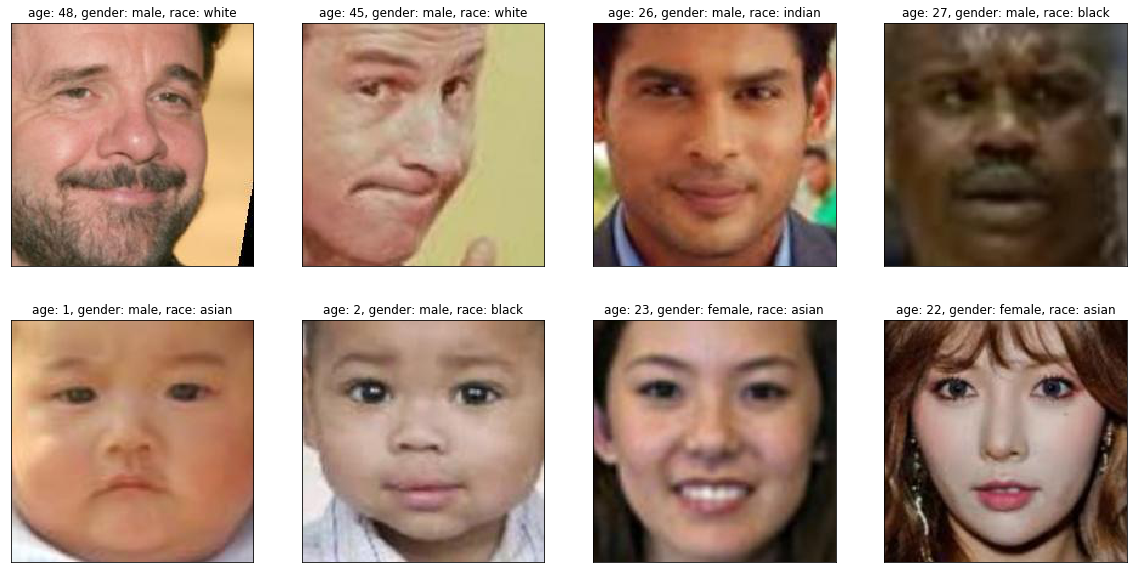

In [11]:
# Dictionary for race mapping
races = ['white','black','asian','indian','other']
raceDict = dict([(x,y) for x,y in enumerate(races)])
# Dictionary for gender mapping
genderDict = {0: 'male', 1: 'female'}

# Plot random images from UTKFace cropped dataset
fig = plt.figure(figsize=(20,10))
faceDir = '../data/UTKFace'

for i in range(8):
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir(faceDir))
    fullFilename = faceDir + '/' + imgFilename
    # Get the image labels
    imgLabels = manualUTKLabels[manualUTKLabels.filename == fullFilename]
    # Load the selected image
    img = load_img(faceDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,4,i+1)
    ax.imshow(img)
    ax.set_title("age: {}, gender: {}, race: {}".format(int(imgLabels.age.values),genderDict[int(imgLabels.gender)],raceDict[int(imgLabels.race)]))
    ax.set_xticks([])
    ax.set_yticks([])
           

The UTK images shown above are very heterogeneous in size, alignment, and the number of faces in the image. To train a model for gender detection, we must have uniform image size and centered facial alignment with a single face per image. This means that we must preprocess the images above to crop, resize, and align a single face per image prior to training the model. Image preprocessing is discussed in the succeeding sections. We used transfer learning of existing models, and as part of that we researched and repurposed some existing image processing code for alignment and cropping. 

### Exploratory Data Analysis

The UTKFace data is the only data the we have that is labeled for race. The distribution of races in the dataset by gender is very imbalanced:
<img src="2019-04-27.png">

The dataset is still predominantly white, though the genders are more balanced. One way to combat the imbalance in the dataset would be to apply class weighting when building the CNN. Another approach may be to cull the number of images of white people that we use thereby forcing a more balanced dataset. Both approaches will be assessed, and we will choose an approach the minimizes the classification error the most.

In [150]:
# Separate data to plot for EDA
plotUTKlabels = manualUTKLabels.iloc[:,0:3]

# Function to remove outliers
def removeOutliers(df,col,SD):
    # Find and remove outliers that are use specified SDs or more away from the median of the data set
    print("Found the following outliers:\n")
    print(df[abs(df[col] - df[col].median()) / df[col].mad() >= SD])
    df[col] = df[col].mask(abs(df[col] - df[col].median()) / df[col].mad() >= SD)
    numOutliers =  df[col].isna().sum()
    print("The {} column has {} outliers within {} standard deviations".format(col,numOutliers,SD))
    print("The statsitics for {} are \n{}".format(col,df[col].describe()))
    print("\n")
    return df.dropna()

# Run the outlier function for age and race
plotUTKlabelsClean = removeOutliers(plotUTKlabels,'race',6)
plotUTKlabelsClean = removeOutliers(plotUTKlabelsClean,'age',6)

Found the following outliers:

       age  gender               race
8115    39       1  20170116174525125
11107   61       1  20170109150557335
15880   61       1  20170109142408075
The race column has 3 outliers within 6 standard deviations
The statsitics for race are 
count    23705.000000
mean         1.269226
std          1.345638
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: race, dtype: float64


Found the following outliers:

Empty DataFrame
Columns: [age, gender, race]
Index: []
The age column has 0 outliers within 6 standard deviations
The statsitics for age are 
count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64




/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


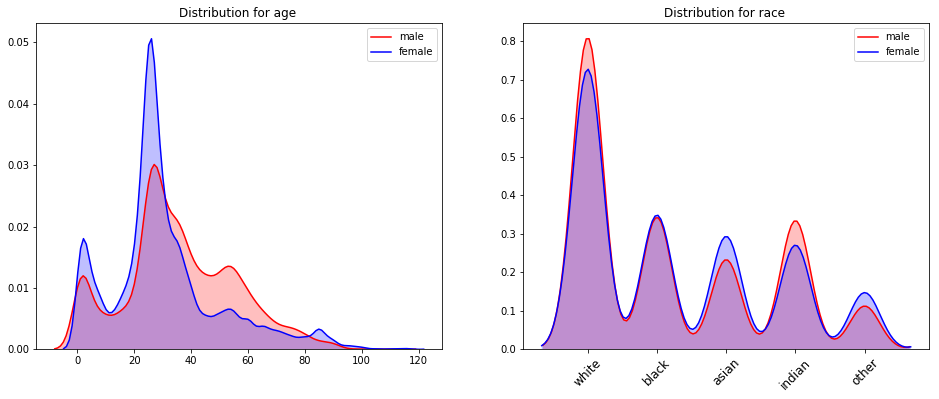

In [167]:
# Setup the figure that will have subplots
fig = plt.figure(figsize=(16,6))
# Loop through all of the columns except for 'plotUTKlabels of votes0 and 'class' and create a subplot for each column
for i,col in zip(range(plotUTKlabelsClean.shape[1] - 1),list(plotUTKlabelsClean.drop(['gender'],axis=1).columns.values)):
    ax = fig.add_subplot(1,2,i+1)
    sns.kdeplot(plotUTKlabelsClean.loc[plotUTKlabelsClean['gender'] == 0,col], shade=True, color="r", label="male",ax=ax)
    sns.kdeplot(plotUTKlabelsClean.loc[plotUTKlabelsClean['gender'] == 1,col], shade=True, color="b", label="female",ax=ax)
    if str(col) == 'race':
        ax.set_xticklabels(['null'] + races, rotation=45, fontsize=12)
    ax.set_title("Distribution for {} ".format(col))

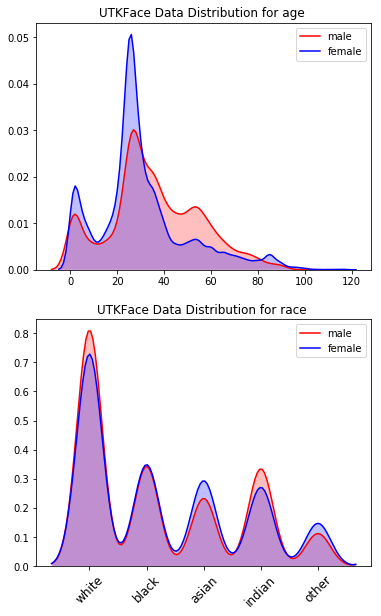

In [174]:
# Setup the figure that will have subplots
fig = plt.figure(figsize=(6,10))
# Loop through all of the columns except for 'plotUTKlabels of votes0 and 'class' and create a subplot for each column
for i,col in zip(range(plotUTKlabelsClean.shape[1] - 1),list(plotUTKlabelsClean.drop(['gender'],axis=1).columns.values)):
    ax = fig.add_subplot(2,1,i+1)
    sns.kdeplot(plotUTKlabelsClean.loc[plotUTKlabelsClean['gender'] == 0,col], shade=True, color="r", label="male",ax=ax)
    sns.kdeplot(plotUTKlabelsClean.loc[plotUTKlabelsClean['gender'] == 1,col], shade=True, color="b", label="female",ax=ax)
    if str(col) == 'race':
        ax.set_xticklabels(['null'] + races, rotation=45, fontsize=12)
    ax.set_title("UTKFace Data Distribution for {} ".format(col))

<a id='models'></a>

## Transfer Learning Models </b></div>

### Model Descriptions

There are some excellent models already available for facial recognition that are trained on tens of thousands of images to classify the identities of thousands of people. A recent Github repository compiled [Dandy Naufaldi](https://www.linkedin.com/in/dandy-naufaldi/) called [Agendernet](https://github.com/dandynaufaldi/Agendernet) provides a nice framework of image preprocessing and model implementation for some of these models that we will build off of in this work. 

The following models are evaluated for this work:
- [InceptionV3](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)
- [MobileNetV2](https://arxiv.org/abs/1801.04381)
- [Insightface](https://github.com/deepinsight/insightface)

All 3 models are implemented and results for gender classification with regard to race are presented and compared.

### Image Preprocessing

Each model has different image preprocessing needs. The Insightface model requires that images be preprocessed using [MTCNN_face_detection_alignment](https://github.com/kpzhang93/MTCNN_face_detection_alignment). InceptionV3 requires images with a size of 140 x 140 pixels whereas MobileNetV2 requires images with a size of 96 x 96 pixels. In all cases, the images are required to contain a single, centered face. As such, we begin by adapting the 'align and save' script by Naufaldi for saving images 

In [194]:
# Function to align and save the preprocessed images into a different directory
def align_and_save(path: str):
    """
    Get aligned face and save to disk

    Parameters
    ----------
    path : string
        path to image

    Returns
    -------
    integer
        flag to mark. 1 if success detect face, 0 if fail
    """

    RES_DIR = 'data/UTK_aligned/'
    if os.path.exists(os.path.join(path)):
        return 1
    #flname = os.path.join(DATASET, path)
    image = cv2.imread(path)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('Algorithmic-Biases-in-Facial-Recognition/Agendernet/model/shape_predictor_5_face_landmarks.dat')
    rects = detector(image, 1)
    print(rects)
    # if detect exactly 1 face, get aligned face
    if len(rects) == 1:
        print('face detected')
        shape = predictor(image, rects[0])
        result = dlib.get_face_chip(image, shape, padding=0.4, size=140)
        folder = os.path.join(RES_DIR, path.split('/')[0])
        if not os.path.exists(folder):
            os.makedirs(folder, exist_ok=True)
        flname = os.path.join(path)
        if not os.path.exists(flname):
            cv2.imwrite(flname, result)
        return 1
    return 0

# Setup the input to the align and save function
imgPath = 'data/UTK/'
numWorkers = 4
predictor = dlib.shape_predictor('Algorithmic-Biases-in-Facial-Recognition/Agendernet/model/shape_predictor_5_face_landmarks.dat')
data = manualUTKLabels.copy()
data = data[0:6]
# detector = dlib.get_frontal_face_detector()

paths = data.loc[0:6,'filename'].values
#paths = data.loc[0,'filename']

print('[PREPROC] Run face alignment...')
with Pool(processes=numWorkers) as p:
    res = []
    max_ = len(paths)
    with tqdm(total=max_) as pbar:
        for i, j in tqdm(enumerate(p.imap(align_and_save, paths))):
            pbar.update()
            res.append(j)
    data['flag'] = res

    # create new db with only successfully detected face
    data = data.loc[data['flag'] == 1, list(data)[:-1]]
    data.to_csv('data/UTK_cleaned.csv', index=False)


[PREPROC] Run face alignment...







  0%|          | 0/6 [00:00<?, ?it/s]





0it [00:00, ?it/s]





6it [00:00, 7449.92it/s]




100%|██████████| 6/6 [00:00<00:00, 864.09it/s]

In [262]:
'''
Code from here:
    https://github.com/ostegm/resizing/blob/master/Resizing.ipynb
originally shared by Otto Stegmaier from fast.ai:
    https://forums.fast.ai/t/impact-of-image-resizing-on-model-training-time-and-performance/1980
'''
# Function that centers and crops an image and resizes for input to Keras VGG16 model
def resize_center_crop(im_arr, desired_shp = 224):
    x,y,_ = im_arr.shape
    ratio = 1.0 * x/y
    if x < y:
        newx, newy = desired_shp, desired_shp/ratio
    elif y < x:
        newx, newy = desired_shp * ratio, desired_shp
    else :
        newx, newy = desired_shp,desired_shp
    newshape = (int(newx), int(newy))
    
    #Resize based shortest side to 'desired_shp'
    im_arr = skimage.transform.resize(im_arr, newshape)
    
    #center crop so both side are equal length
    left, right = (newx - desired_shp)/2, (newx + desired_shp)/2
    top, bottom = (newy - desired_shp)/2, (newy + desired_shp)/2
    return im_arr[int(left):int(right),int(top):int(bottom)]

<a id='results'></a>

In [238]:
from keras.applications.inception_v3 import InceptionV3

In [266]:
class AgenderNetInceptionV3(Model):
    """Classification model based on InceptionV3 with 2 outputs, each for age and gender
    """

    def __init__(self):
        self.input_size = 140
        base = InceptionV3(
            input_shape=(140, 140, 3),
            include_top=False,
            #weights=os.path.dirname(os.path.abspath())+'/weight/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
            weights=os.getcwd() + '/model/weight/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
        top_layer = GlobalAveragePooling2D(name='avg_pool')(base.output)
        gender_layer = Dense(2, activation='softmax', name='gender_prediction')(top_layer)
        age_layer = Dense(101, activation='softmax', name='age_prediction')(top_layer)
        super().__init__(inputs=base.input, outputs=[gender_layer, age_layer], name='AgenderNetInceptionV3')

    def prep_phase1(self):
        """Freeze layer from input until mixed10 (before last GlobalAveragePooling2D)
        """
        for layer in self.layers[:311]:
            layer.trainable = False
        for layer in self.layers[311:]:
            layer.trainable = True

    def prep_phase2(self):
        """Freeze layer from input until mixed5
        """
        for layer in self.layers[:165]:
            layer.trainable = False
        for layer in self.layers[165:]:
            layer.trainable = True

    @staticmethod
    def decode_prediction(prediction):
        """
        Decode prediction to age and gender prediction.
        Use softmax regression for age and argmax for gender.
        Parameters
        ----------
        prediction : list of numpy array
            Result from model prediction [gender, age]
        Return
        ----------
        gender_predicted : numpy array
            Decoded gender 1 male, 0 female
        age_predicted : numpy array
            Age from softmax regression
        """
        gender_predicted = np.argmax(prediction[0], axis=1)
        age_predicted = prediction[1].dot(np.arange(0, 101).reshape(101, 1)).flatten()
        return gender_predicted, age_predicted

    @staticmethod
    def prep_image(data):
        """Preproces image specific to model

        Parameters
        ----------
        data : numpy ndarray
            Array of N images to be preprocessed

        Returns
        -------
        numpy ndarray
            Array of preprocessed image
        """
        data = data.astype('float16')
        data /= 127.5
        data -= 1.
        for i in data:
            data[i] = resize_center_crop(data[i], desired_shp = 140)
        return data


if __name__ == '__main__':
    model = AgenderNetInceptionV3()
    print(model.summary())
    for (i, layer) in enumerate(model.layers):
        print(i, layer.name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 140, 140, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1411 (Conv2D)            (None, 69, 69, 32)   864         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1411 (Batch (None, 69, 69, 32)   96          conv2d_1411[0][0]                
__________________________________________________________________________________________________
activation_1411 (Activation)    (None, 69, 69, 32)   0           batch_normalization_1411[0][0]   
__________________________________________________________________________________________________
conv2d_141

In [290]:
#from model.inceptionv3 import AgenderNetInceptionV3
#from model.mobilenetv2 import AgenderNetMobileNetV2
#from model.ssrnet import AgenderSSRNet
from utils.generator import DataGenerator
from utils.callback import DecayLearningRate

def load_data():
    """
    Load dataset (IMDB, Wiki, Adience)

    Returns
    -------
    db : numpy ndarray
        array of db name
    paths : numpy ndarray
        array of image paths
    age_label : numpy ndarray
        array of age labels
    gender_label : numpy ndarray
        array of gender labels
    """

    data = pd.read_csv('data/UTK_cleaned.csv')

    db = data['db_name'].values
    #db = 'data/UTK'
    paths = data['filename'].values
    age_label = data['age'].values.astype('uint8')
    gender_label = data['gender'].values.astype('uint8')
    return db, paths, age_label, gender_label


def mae(y_true, y_pred):
    """Custom MAE for 101 age class, apply softmax regression

    Parameters
    ----------
    y_true : tensor
        ground truth
    y_pred : tensor
        prediction from model

    Returns
    -------
    float
        MAE score
    """

    return K.mean(K.abs(K.sum(K.cast(K.arange(0, 101), dtype='float32') * y_pred, axis=1) -
                        K.sum(K.cast(K.arange(0, 101), dtype='float32') * y_true, axis=1)), axis=-1)


def main(epoch,batch_size,workers=4):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.tensorflow_backend.set_session(sess)

    MODEL = 'inceptionv3'
    EPOCH = epoch
    BATCH_SIZE = batch_size
    NUM_WORKER = workers

    db, paths, age_label, gender_label = load_data()
    n_fold = 1
    print('[K-FOLD] Started...')
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    kf_split = kf.split(age_label)
    for train_idx, test_idx in kf_split:
        model = None
        if MODEL == 'ssrnet':
            model = AgenderSSRNet(64, [3, 3, 3], 1.0, 1.0)
        elif MODEL == 'inceptionv3':
            print('Using InceptionV3')
            model = AgenderNetInceptionV3()
        else:
            model = AgenderNetMobileNetV2()
        train_db = db[train_idx]
        train_paths = paths[train_idx]
        train_age = age_label[train_idx]
        train_gender = gender_label[train_idx]

        test_db = db[test_idx]
        test_paths = paths[test_idx]
        test_age = age_label[test_idx]
        test_gender = gender_label[test_idx]

        losses = {
            "age_prediction": "categorical_crossentropy",
            "gender_prediction": "categorical_crossentropy",
        }
        metrics = {
            "age_prediction": mae,
            "gender_prediction": "acc",
        }
        if MODEL == 'ssrnet':
            losses = {
                "age_prediction": "mae",
                "gender_prediction": "mae",
            }
            metrics = {
                "age_prediction": "mae",
                "gender_prediction": "binary_accuracy",
            }

        callbacks = [
            ModelCheckpoint(
                "train_weight/weights.{epoch:02d}-{val_loss:.2f}.h5",
                verbose=1, save_best_only=True, save_weights_only=True),
            CSVLogger('Algorithmic-Biases-in-Facial-Recognition/train_log/{}-{}.log'.format(MODEL, n_fold))]
        if MODEL == 'ssrnet':
            callbacks = [
                ModelCheckpoint(
                    "Algorithmic-Biases-in-Facial-Recognition/train_weight/weights.{epoch:02d}-{val_loss:.4f}.h5",
                    verbose=1, save_best_only=True, save_weights_only=True),
                CSVLogger('train_log/{}-{}.log'.format(MODEL, n_fold)),
                DecayLearningRate([30, 60])]
        model.compile(optimizer='adam', loss=losses, metrics=metrics)
        model.fit_generator(
            DataGenerator(model, train_db, train_paths, train_age, train_gender, BATCH_SIZE),
            validation_data=DataGenerator(model, test_db, test_paths, test_age, test_gender, BATCH_SIZE),
            epochs=EPOCH,
            verbose=2,
            workers=NUM_WORKER,
            use_multiprocessing=True,
            max_queue_size=int(BATCH_SIZE * 2),
            callbacks=callbacks
        )
        n_fold += 1
        del train_db, train_paths, train_age, train_gender
        del test_db, test_paths, test_age, test_gender


In [291]:
epoch = 5
batch_size = 32
workers = 4
main(epoch,batch_size,workers=4)

[K-FOLD] Started...
Using InceptionV3
Epoch 1/5


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


## Results </b></div>

### Base case gender classification with pre-trained models



In [4]:
import keras
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
keras.backend.set_image_dim_ordering('tf')

In [36]:
# Function for calculating the VGGFace model 
def VGGFaceModel(x,modelType):
    # Instantiate the model
    model = VGGFace(model=modelType)
    # Expand the dimensions of the img
    x = np.expand_dims(x, axis=0)
    if modelType == 'vgg16':
        x = utils.preprocess_input(x, version=1)
    else:
        x = utils.preprocess_input(x, version=2)
    preds = model.predict(x)
    return utils.decode_predictions(preds)

Preprocess images by cropping and resizing them

CPU times: user 84 ms, sys: 16 ms, total: 100 ms
Wall time: 102 ms


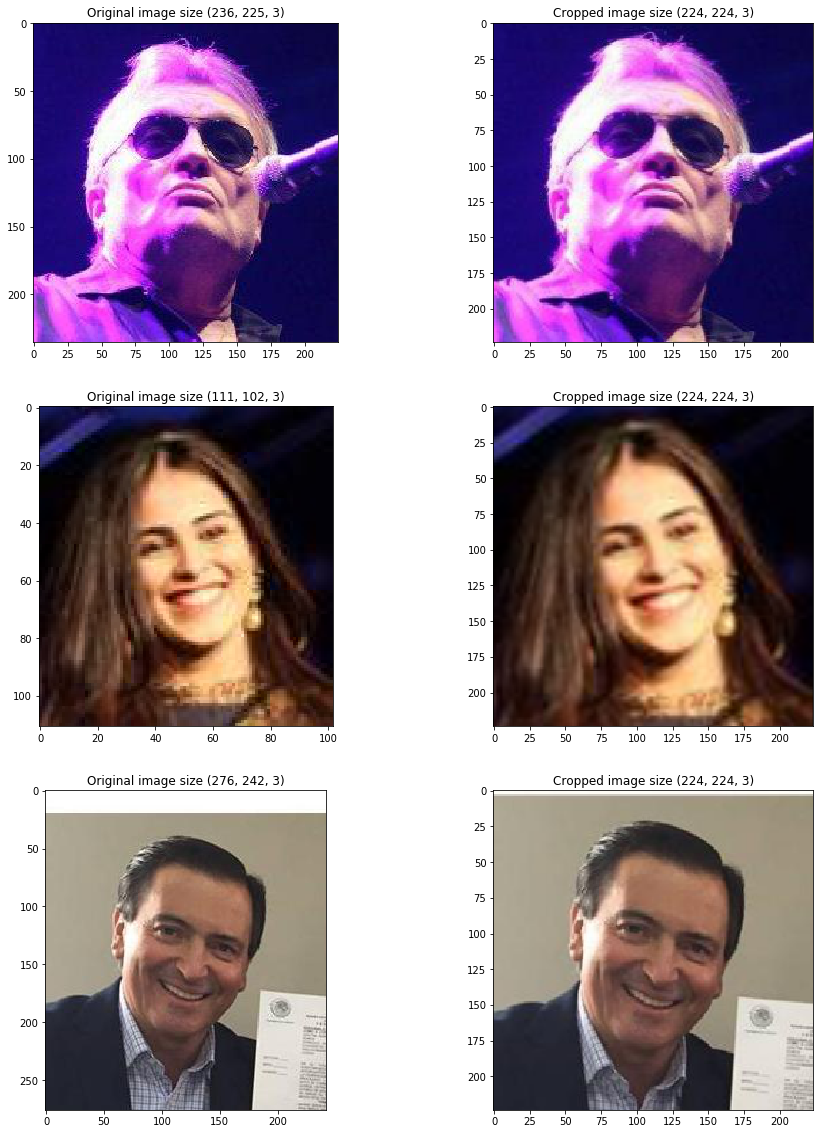

In [33]:
%%time
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(16,20))
outer = gridspec.GridSpec(3, 1, wspace=0.2, hspace=0.2)

for i in range(3):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    randDir2 = np.random.choice(os.listdir("test/"+randDir))
    # Image filename
    imgFilename = "test/" + randDir + "/" + randDir2
    # Call the model function
    img = load_img(imgFilename)
    # Convert to an array for plotting
    img = img_to_array(img)
    # Crop and resize the images
    imgCropped = resize_center_crop(img, desired_shp = 224)
    # Get the actual person
    imgActual = vggIdentity.loc[vggIdentity.Class_ID == randDir,'Name'].values
    # Define the inner picture grid to plot
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    # Add to the subplot inner figure
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(img/255.0)
    ax.set_title("Original image size {}".format(img.shape))
    ax  = fig.add_subplot(ax)
    # Add to the subplot inner figure
    ax = plt.Subplot(fig, inner[1])
    ax.imshow(imgCropped/255.0)
    ax.set_title("Cropped image size {}".format(imgCropped.shape))
    ax  = fig.add_subplot(ax)
    

Test out the VGGface model for image identification of celebrities using the VGG testing dataset.

CPU times: user 6min 50s, sys: 1.31 s, total: 6min 52s
Wall time: 6min 51s


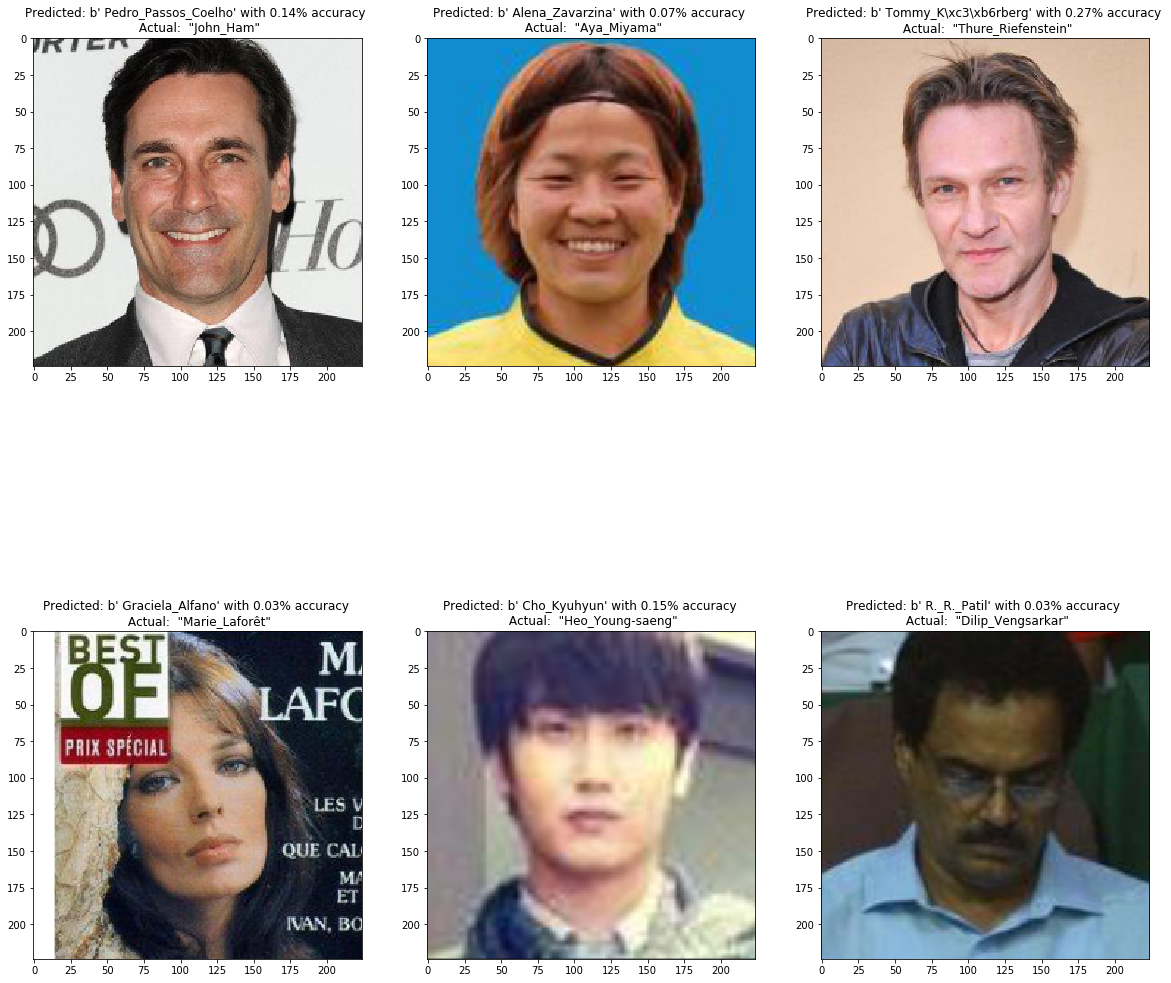

In [42]:
%%time
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,20))

for i in range(6):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    randDir2 = np.random.choice(os.listdir("test/"+randDir))
    # Image filename
    imgFilename = "test/" + randDir + "/" + randDir2
    # Load the image
    img = image.load_img(imgFilename)
    # Image to array using the VGGface function (in image)
    img = image.img_to_array(img)
    # Crop and resize the images
    imgCropped = resize_center_crop(img, desired_shp = 224)
    # Make prediction with the model
    imgPred = VGGFaceModel(imgCropped,'resnet50')
    # Get the actual person
    imgActual = vggIdentity.loc[vggIdentity.Class_ID == randDir,'Name'].values
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,3,i+1)
    ax.imshow(imgCropped/255.0)
    ax.set_title("Predicted: {} with {}% accuracy \n Actual: {}".format(imgPred[0][0][0],str(imgPred[0][0][1])[0:4],imgActual[0]))
    

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [99]:
'''
Adapted from:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
'''

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, genPath, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(genPath + ID)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Example of how to use this with VGGFace2:

In [133]:
# Prepare the VGG data labels for each image
#vggTrainTmp = vggTrain.imageid.str.split("/",expand = True).add_prefix('imageid')
#vggTestTmp = vggTest.imageid.str.split("/",expand = True).add_prefix('imageid')

# Train directory
trainDir = "../data/train/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(trainDir)
# Empty data frame to start from
vggTrainTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(trainDir + d)).rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTrainTmp = pd.concat([vggTrainTmp,subDirList], axis=0, sort=False)

# Test directory
testDir = "../data/test/"
# Get the training sample IDs from the directory in case all of the data hasn't been loaded
dirList = os.listdir(testDir)
# Empty data frame to start from
vggTestTmp = pd.DataFrame()
# Loop through subdirectories to get dataframe of images
for d in dirList:
    subDirList = pd.DataFrame(os.listdir(testDir + d)).rename(columns={subDirList.columns[0]:'imageid1'})
    # Add in the sample ID
    subDirList['imageid0'] = d
    # Concatenate to make a dataframe of IDs
    vggTestTmp = pd.concat([vggTestTmp,subDirList], axis=0, sort=False)
    
# Merge the ID columns to assign the right labels to each image
vggIdentityTrain = pd.merge(vggIdentity,vggTrainTmp,right_on='imageid0',left_on='Class_ID')
# Merge the ID columns to assign the right labels to each image
vggIdentityTest = pd.merge(vggIdentity,vggTestTmp,right_on='imageid0',left_on='Class_ID')
# Create a new column with the full image name so that the IDs are equal
vggIdentityTrain['imageid'] = vggIdentityTrain['imageid0'].str.cat(vggIdentityTrain['imageid1'],sep="/")
# Create a new column with the full image name so that the IDs are equal
vggIdentityTest['imageid'] = vggIdentityTest['imageid0'].str.cat(vggIdentityTest['imageid1'],sep="/")

# Parameters for RGB image with dimensions 224x224
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(vggIdentityTrain['imageid'], vggIdentityTrain['Gender'], trainDir, **params)
validation_generator = DataGenerator(vggIdentityTest['imageid'], vggIdentityTest['Gender'], testDir, **params)

# MODEL MUST BE SET UP TO GET THE TRAINING GENERATOR LIKE THIS
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6) # enter the number of threads to be used to generate batches in parallel

In [1]:
IM_HEIGHT = IM_WIDTH = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

In [2]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape= (IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[gender_output])
model.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 194, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 95, 95, 96)        55392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 95, 95, 96)        384       
__________

In [9]:
from keras.utils.vis_utils import plot_model
#import pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.